In [1]:
from random import shuffle
from typing import Any
import tensorflow as tf
from pathlib import Path
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
print(tf.config.list_physical_devices('GPU'))

2024-02-24 09:08:46.490800: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-24 09:08:46.794357: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-24 09:08:46.794427: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-24 09:08:46.845939: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-24 09:08:46.927353: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-02-24 09:08:51.029033: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 09:08:51.140324: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 09:08:51.146145: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
class DataGenerator:
    def __init__(self,
                 path,
                 crop_size=128,
                 rho=16):
        self.crop_size = crop_size
        self.rho = rho

        # find all images in the path
        if isinstance(path,str):
            path = Path(path)
        self.im_list = list(path.glob("*.jpg"))
        self.nimg = len(self.im_list)
        shuffle(self.im_list)
        self.ifile=0

    def gen_img_and_homography(self,img_path,debug=False):
    
        # read image
        im_data = np.array(Image.open(img_path))
        if im_data.ndim < 3: # skip single channel
            return None, None
        h,w = im_data.shape[:2]

        # randomly select the corners for cropping
        # making sure the shifted corners are within the image
        if isinstance(self.crop_size,int):
            ch = self.crop_size
            cw = self.crop_size
        else: # list of crop size
            ch,cw = self.crop_size

        if h-self.rho-ch <= self.rho or w-self.rho-cw <= self.rho:
            return None, None

        # choose upper left corner
        upper_left_h = np.random.randint(low=self.rho,high=h-self.rho-ch)
        upper_left_w = np.random.randint(low=self.rho,high=w-self.rho-cw)

        corner_pts = np.array([[0,0],[ch-1,0],[ch-1,cw-1],[0,cw-1]]) + \
                    np.array([upper_left_h, upper_left_w])[np.newaxis,:]
        corner_pts_new = np.copy(corner_pts)
        # generate the new 4 corner points
        for i in range(4):
            corner_pts_new[i,:] += np.random.randint(-self.rho,
                                                     self.rho+1,
                                                     size=(2,))
        # note H map from corners new back to original corners

        # calculate the difference in xy coordinate
        H4pt = (corner_pts - corner_pts_new).flatten()

        # get actual homography
        H = cv2.getPerspectiveTransform(np.fliplr(corner_pts_new.astype(np.float32)),
                                    np.fliplr(corner_pts.astype(np.float32)))
        
        im_warp = cv2.warpPerspective(im_data, H, (w,h))

        # get the two patches
        p1 = im_data[upper_left_h:upper_left_h+ch,upper_left_w:upper_left_w+cw]
        p2 = im_warp[upper_left_h:upper_left_h+ch,upper_left_w:upper_left_w+cw]

        p1 = tf.convert_to_tensor(p1, dtype=tf.float32)
        p2 = tf.convert_to_tensor(p2, dtype=tf.float32)

        # p1 = p1/255.0
        # p2 = p2/255.0

        if debug:
            # sanity check, check the coordinate of the corners
            for i in range(4):
                tmp = H.dot(np.array([corner_pts_new[i,1],
                                            corner_pts_new[i,0],
                                            1.0])[:,np.newaxis])
                print(corner_pts[i,:],np.flipud(tmp[:2]).flatten()/tmp[2])
            plt.imshow(np.hstack((p1/255, p2/255)))

        input = (p1,p2)
        output = tf.convert_to_tensor(H4pt,dtype=tf.float32)
        return input, output

    def __call__(self, *args: Any, **kwds: Any) -> Any:
        while True:
            im_path = self.im_list[self.ifile]
            self.ifile = (self.ifile+1)%self.nimg
            im_crop, h4pt = self.gen_img_and_homography(im_path)
            if im_crop is None:
                continue
            yield im_crop, h4pt

# training set data generator
train_path = Path("..") / "Phase2" / "Data" / "Train"
train_gen = DataGenerator(train_path)

# tensorflow dataset
im_shape = (train_gen.crop_size,train_gen.crop_size,3)
output_signature = ((tf.TensorSpec(shape=im_shape,dtype=tf.float32),
                     tf.TensorSpec(shape=im_shape,dtype=tf.float32)),
                     tf.TensorSpec(shape = (8,),dtype=tf.float32),
                    )
train_ds = tf.data.Dataset.from_generator(train_gen,
                                          output_signature=output_signature)

def config_ds(ds):
    AUTOTUNE = tf.data.AUTOTUNE
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    ds = ds.batch(32)
    return ds

train_ds = config_ds(train_ds)


2024-02-24 09:09:02.970173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 09:09:02.982434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-24 09:09:02.990264: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
from keras.applications.vgg19 import VGG19, preprocess_input

base = VGG19(
    include_top=False,
    weights='imagenet',
    input_shape=(128,128,3),
    pooling='max'
)
base.trainable = False

# retrieve only some part of the base
input = base.input
output = base.get_layer('block3_conv4').output

base2 = tf.keras.Model(inputs=input, outputs=output)
base2.trainable = False
base2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [5]:
from keras.layers import BatchNormalization as BN

im_shape = (128,128,3)
input1 = tf.keras.layers.Input(shape=im_shape)
input2 = tf.keras.layers.Input(shape=im_shape)

x1 = preprocess_input(input1)
x2 = preprocess_input(input2)

x1 = base2(x1)
x2 = base2(x2)

x = tf.keras.layers.Concatenate()((x1,x2)) # 32 by 32 by 512

x = tf.keras.layers.Conv2D(filters=256,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same')(x)
x = BN()(x)

x = tf.keras.layers.Conv2D(filters=256,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same')(x)
x = BN()(x)

x = tf.keras.layers.Conv2D(filters=256,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same')(x)
x = BN()(x)

x = tf.keras.layers.Conv2D(filters=256,
                            kernel_size=(3,3),
                            activation='relu',
                            padding='same')(x)
x = BN()(x)

# add some 3x3 conv
x = tf.keras.layers.Conv2D(filters=256,
                            kernel_size=(3,3),
                            strides=(2,2),
                            activation='relu',
                            padding='same')(x)

x = BN()(x)

x = tf.keras.layers.Conv2D(filters=256,
                            kernel_size=(3,3),
                            strides=(2,2),
                            activation='relu',
                            padding='same')(x)

x = BN()(x)
# # add 1x1 conv
# x = tf.keras.layers.Conv2D(filters=256,
#                             kernel_size=(1,1),
#                             activation='relu')(x)

x = tf.keras.layers.Flatten()(x)
x = BN()(x)
# x = tf.keras.layers.LayerNormalization()(x)

x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = BN()(x)
x = tf.keras.layers.Dense(units=512, activation='relu')(x)
x = BN()(x)
output = tf.keras.layers.Dense(units=8,activation=None)(x)

model = tf.keras.Model(inputs=[input1,input2],outputs=output)
model.summary()

for l in model.layers:
    print(l.name, l.trainable)

def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.norm(y_true-y_pred,axis=1))

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=custom_loss)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 tf.__operators__.getitem (  (None, 128, 128, 3)          0         ['input_2[0][0]']             
 SlicingOpLambda)                                                                                 
                                                                                                  
 tf.__operators__.getitem_1  (None, 128, 128, 3)          0         ['input_3[0][0]']       

In [6]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss',
                                                factor=0.2,
                                                patience=5,
                                                min_lr=1e-6,
                                                verbose=1,
                                                cooldown=5)

history = model.fit(train_ds,epochs=150,verbose=True,steps_per_epoch=150,
                    callbacks=[reduce_lr])

Epoch 1/150


2024-02-24 09:10:39.915147: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-24 09:10:40.072874: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-24 09:10:41.527930: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-24 09:10:41.889763: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fcff429ace0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-24 09:10:41.889794: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-02-24 09:10:41.897544: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1708783841.962521   12843 devic

150/150 [==============================] - 42s 232ms/step - loss: 25.5087 - lr: 0.0010
Epoch 2/150
150/150 [==============================] - 32s 212ms/step - loss: 21.6179 - lr: 0.0010
Epoch 3/150
150/150 [==============================] - 31s 210ms/step - loss: 18.9446 - lr: 0.0010
Epoch 4/150
150/150 [==============================] - 31s 209ms/step - loss: 16.3879 - lr: 0.0010
Epoch 5/150
150/150 [==============================] - 32s 211ms/step - loss: 14.6101 - lr: 0.0010
Epoch 6/150
150/150 [==============================] - 32s 211ms/step - loss: 13.1867 - lr: 0.0010
Epoch 7/150
150/150 [==============================] - 32s 211ms/step - loss: 12.5247 - lr: 0.0010
Epoch 8/150
150/150 [==============================] - 32s 210ms/step - loss: 11.5966 - lr: 0.0010
Epoch 9/150
150/150 [==============================] - 32s 213ms/step - loss: 11.1050 - lr: 0.0010
Epoch 10/150
150/150 [==============================] - 32s 213ms/step - loss: 10.7191 - lr: 0.0010
Epoch 11/150
150/150 

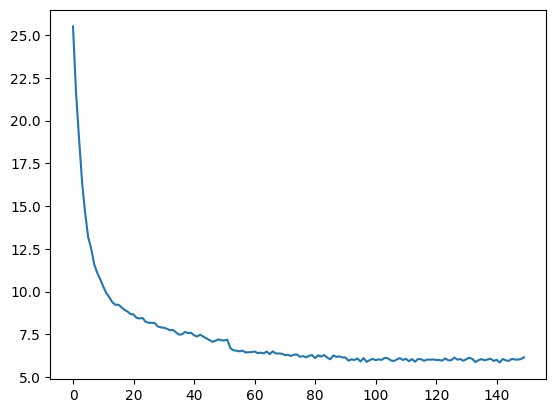

In [7]:
plt.plot(history.history['loss'])